# Binary Classification Challenge

In this challenge, we were tasked to experiment with **binary classification problems**. We will generate different 2D datasets for classification, and discuss how well our decision boundaries fit into the data (if there is overfitting or underfitting), evaluation metrics and the parameters that influence them; like the loss function, the amount of noise introduced in the datasets and the shape of the datasets themselves.

In [1]:
import numpy as np
import datetime
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
import torch.optim as optim
import torch.nn as nn
import sklearn.datasets as dsets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score

%matplotlib inline
plt.style.use('fivethirtyeight')

# Architecture class

We will use an architecture class provided to us in class. This class will be initially configured with the model to be trained, the loss function and the optimizer. Then we can set the device to run on, the data loaders for the training and validation steps, and the seed. Afterwards, we can train the model, get the values for our loss function and make predictions.

In [2]:
class Architecture(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)

    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename,weights_only=False)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

# Generating the data

For the data generation, we will define an enum of supported shapes to test our algorithm with. The advantage of using enums is that I can iterate over the class to get all possible shapes.

In [3]:
from enum import Enum, auto

class DataShape(Enum):
    MOONS = auto()
    CIRCLES = auto()
    BLOBS = auto()

def sklearnDataset(shape : DataShape, n_samples : int, noise : float = 0.0, random_state : int = 42):
    if shape == DataShape.MOONS:
        return dsets.make_moons(n_samples, noise=noise, random_state=random_state)
    elif shape == DataShape.CIRCLES:
        return dsets.make_circles(n_samples, noise=noise, random_state=random_state)
    elif shape == DataShape.BLOBS:
        return dsets.make_blobs(n_samples=n_samples, centers=2, cluster_std=noise + 0.5, random_state=random_state, center_box=(-2, 2))

    raise RuntimeError("The selected shape is not supported.")

class Dataset:
    def __init__(self, shape : DataShape, n_samples, noise, test_size, batch_size=32, random_state=42):
        self.shape = shape
        self.n_samples = n_samples
        self.noise = noise
        self.test_size = test_size
        self.batch_size = batch_size
        self.random_state = random_state

        X, y = sklearnDataset(shape, n_samples, noise, random_state)
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )

        scaler = StandardScaler()
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_val = scaler.transform(self.X_val)

        self.X_train_tensor = torch.as_tensor(self.X_train).float()
        self.y_train_tensor = torch.as_tensor(self.y_train.reshape(-1, 1)).float()
        self.X_val_tensor   = torch.as_tensor(self.X_val).float()
        self.y_val_tensor   = torch.as_tensor(self.y_val.reshape(-1, 1)).float()

        self.train_loader = DataLoader(
            TensorDataset(self.X_train_tensor, self.y_train_tensor),
            batch_size=batch_size, shuffle=True
        )
        self.val_loader   = DataLoader(
            TensorDataset(self.X_val_tensor, self.y_val_tensor),
            batch_size=batch_size, shuffle=False
        )

In [14]:
def plotDataset(dataset : Dataset, cm_bright = None):
    if cm_bright is None:
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    figs, axes = plt.subplots(1, 2, figsize=(4,1.5), dpi=300)

    axes[0].scatter(dataset.X_train[:, 0], dataset.X_train[:, 1], c=dataset.y_train, cmap=cm_bright, s=4)
    axes[0].set_xlabel('X₁', fontsize=4)
    axes[0].set_ylabel('X₂', fontsize=4)
    axes[0].set_title(str(dataset.shape) + ' Dataset (train)', fontsize=4)
    axes[0].tick_params(axis='both', labelsize=4)

    axes[1].scatter(dataset.X_val[:, 0], dataset.X_val[:, 1], c=dataset.y_val, cmap=cm_bright, s=4)
    axes[1].set_xlabel('X₁', fontsize=4)
    axes[1].set_ylabel('X₂', fontsize=4)
    axes[1].set_title(str(dataset.shape) + ' Dataset (validation)', fontsize=4)
    axes[1].tick_params(axis='both', labelsize=4)

    plt.tight_layout

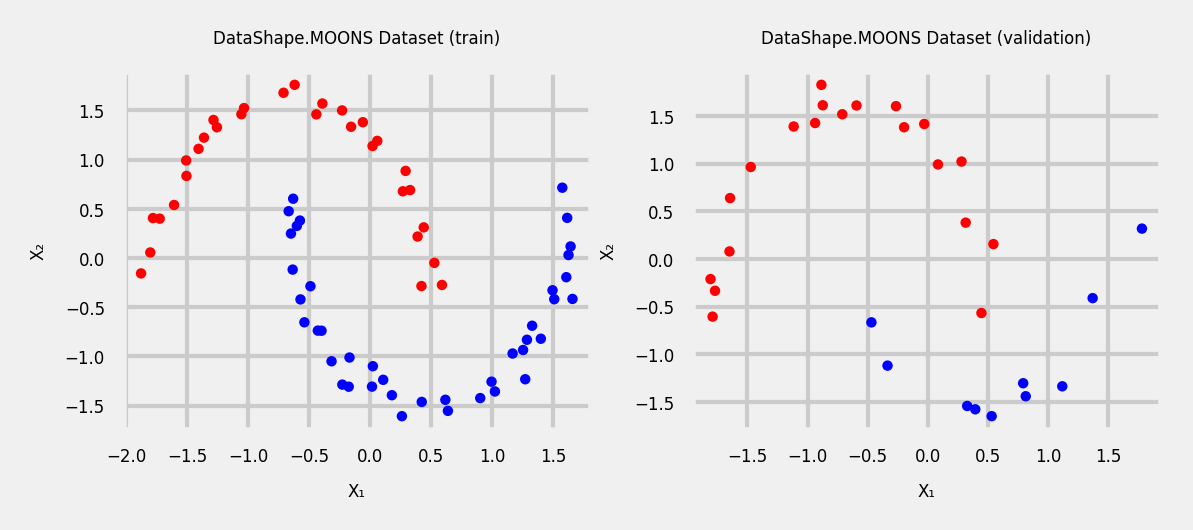

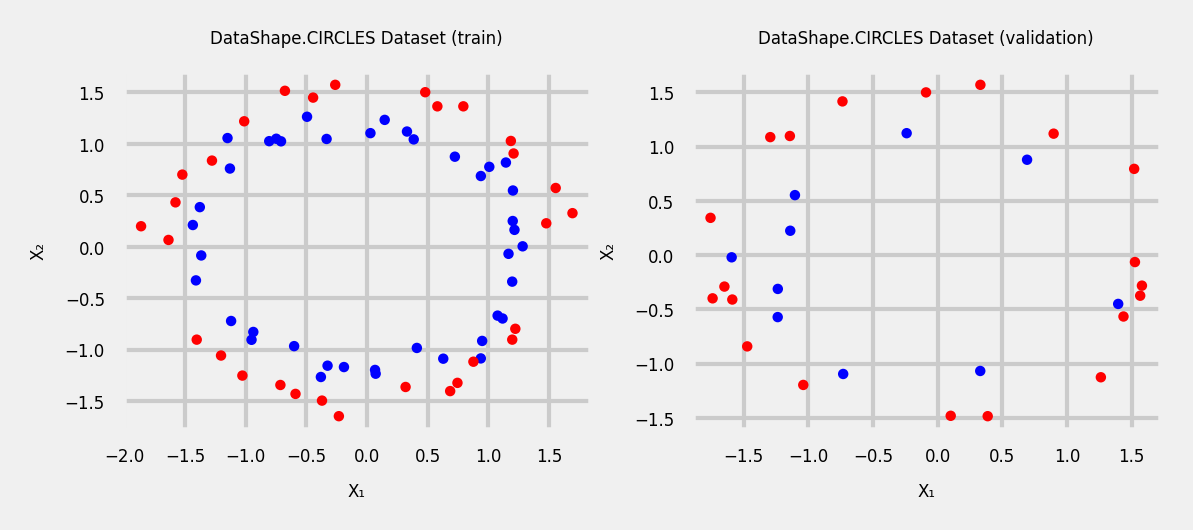

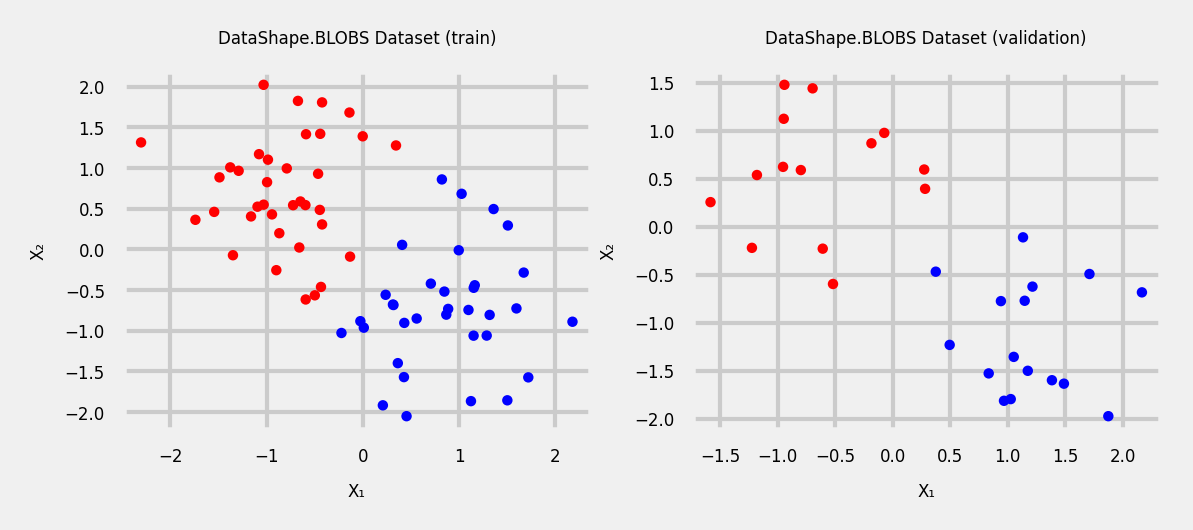

In [15]:
datasets_example = {}
for shape in DataShape:
    datasets_example[shape] = Dataset(shape, 100, 0.05, 0.3)

for dataset in datasets_example.values():
    plotDataset(dataset)

With this, we can generate datasets with different levels of noise and shapes.

# Training the models

Now, we need to prepare our pytorch environment for the data we will generate and train the models.

In [16]:
noises = [0, 0.01, 0.05, 0.1, 0.15, 0.2]

class LossFunc:
    def __init__(self, name : str, loss_fn):
        self.name = name
        self.fn = loss_fn

loss_fns = [LossFunc("BCELoss", nn.BCELoss()), LossFunc("BCEWithLogitsLoss", nn.BCEWithLogitsLoss())]


In [17]:
torch.manual_seed(42)
lr = 0.1
n_epochs = 200

archs = {}

for i, shape in enumerate(DataShape):
    archs[shape] = {}
    for j, loss_fn in enumerate(loss_fns):
        archs[shape][loss_fn.name] = {}
        for k, noise in enumerate(noises):
            print(f'Training dataset with shape {shape}, loss function {loss_fn.name} and noise = {noise}')
            dataset = Dataset(shape, 200, noise, 0.3, 16)

            model = nn.Sequential()
            if loss_fn.name == "BCELoss":
                # Wrap sigmoid to get probabilities
                model.add_module('linear', nn.Linear(2, 1))
                model.add_module('sigmoid', nn.Sigmoid())
            else:
                # BCEWithLogitsLoss expects raw logits
                model.add_module('linear', nn.Linear(2, 1))

            optimizer = optim.SGD(model.parameters(), lr=lr)

            arch = Architecture(model, loss_fn.fn, optimizer)
            archs[shape][loss_fn.name][noise] = arch
            arch.set_loaders(dataset.train_loader, dataset.val_loader)
            arch.set_seed(42)
            arch.train(n_epochs)

Training dataset with shape DataShape.MOONS, loss function BCELoss and noise = 0
Training dataset with shape DataShape.MOONS, loss function BCELoss and noise = 0.01
Training dataset with shape DataShape.MOONS, loss function BCELoss and noise = 0.05
Training dataset with shape DataShape.MOONS, loss function BCELoss and noise = 0.1
Training dataset with shape DataShape.MOONS, loss function BCELoss and noise = 0.15
Training dataset with shape DataShape.MOONS, loss function BCELoss and noise = 0.2
Training dataset with shape DataShape.MOONS, loss function BCEWithLogitsLoss and noise = 0
Training dataset with shape DataShape.MOONS, loss function BCEWithLogitsLoss and noise = 0.01
Training dataset with shape DataShape.MOONS, loss function BCEWithLogitsLoss and noise = 0.05
Training dataset with shape DataShape.MOONS, loss function BCEWithLogitsLoss and noise = 0.1
Training dataset with shape DataShape.MOONS, loss function BCEWithLogitsLoss and noise = 0.15
Training dataset with shape DataSha

# Results

To check our results, we will make some functions to plot them:

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def plot_decision_boundary(X, y, arch, ax=None, title=None):
    h = 0.02
    x_min, x_max = X[:,0].min() - .5, X[:,0].max() + .5
    y_min, y_max = X[:,1].min() - .5, X[:,1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    grid = np.c_[xx.ravel(), yy.ravel()]
    logits = arch.predict(grid)

    if isinstance(arch.loss_fn, torch.nn.BCELoss):
        probs = logits
    else:
        probs = sigmoid(logits)

    probs = probs.reshape(xx.shape)

    contour = ax.contourf(xx, yy, probs, 25, cmap=plt.cm.RdBu, alpha=0.6, vmin=0, vmax=1)
    ax.contour(xx, yy, probs, levels=[0.5], colors='k')
    ax.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdBu, edgecolors='k', s=15)

    ax.set_xlabel("Feature 1", fontsize=8)
    ax.set_ylabel("Feature 2", fontsize=8)
    ax.tick_params(axis='both', labelsize=6)
    if title:
        ax.set_title(title, fontsize=9)
    cbar = plt.colorbar(contour, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=4)

def compute_metrics(y_true, y_pred, loss_name=None):
    y_true = np.asarray(y_true).astype(int).ravel()
    arr = np.asarray(y_pred).ravel()

    if loss_name == "BCEWithLogitsLoss":
        probs = torch.sigmoid(torch.as_tensor(arr)).numpy()
    else:
        probs = arr

    preds = (probs >= 0.5).astype(int)

    cm = confusion_matrix(y_true, preds)
    acc = accuracy_score(y_true, preds)
    precision = precision_score(y_true, preds, zero_division=0)
    recall = recall_score(y_true, preds, zero_division=0)

    return cm, acc, precision, recall, probs

def plot_metrics(arch_subset, loss_name='BCELoss', shape_name="Moons"):
    for noise in noises:
        arch = arch_subset[noise]

        X_val = arch.val_loader.dataset.tensors[0].numpy()
        y_val = arch.val_loader.dataset.tensors[1].numpy().flatten()

        predictions = arch.predict(X_val)
        probs_val = predictions.flatten()

        cm, acc, prec, rec, _ = compute_metrics(y_val, probs_val, loss_name)

        fig, axes = plt.subplots(1, 2, figsize=(9, 4))

        # decision boundary
        plot_decision_boundary(X_val, y_val, arch, ax=axes[0], title=f"Decision Boundary\nNoise={noise:.3f}")

        # confusion matrix heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1], cbar=False, annot_kws={"size": 7})
        axes[1].set_xlabel('Predicted', fontsize=8)
        axes[1].set_ylabel('True', fontsize=8)
        axes[1].set_title(f"Confusion Matrix\nAcc={acc:.2f}, Prec={prec:.2f}, Rec={rec:.2f}", fontsize=9)
        axes[1].tick_params(axis='both', labelsize=7)

        plt.suptitle(f"{shape_name} - {loss_name} (Noise={noise:.3f})", fontsize=10)
        plt.tight_layout()
        plt.show()

        arch.plot_losses()

## Moons with BCELoss

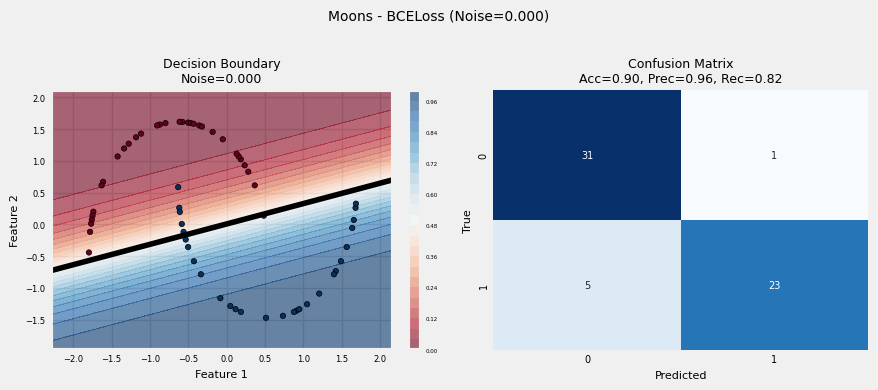

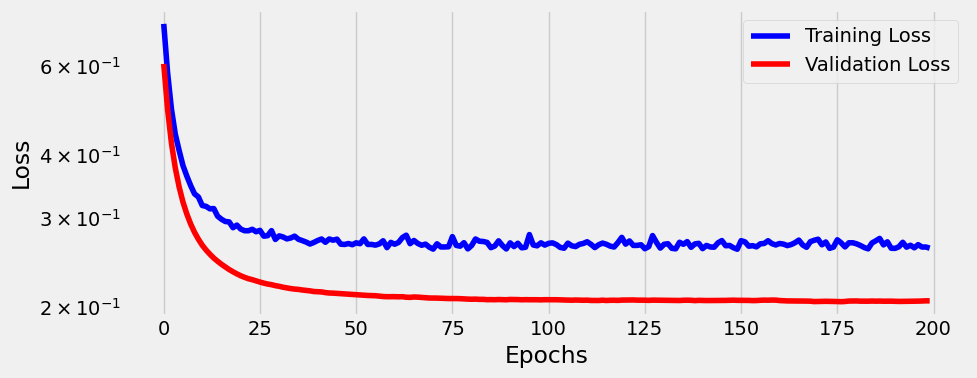

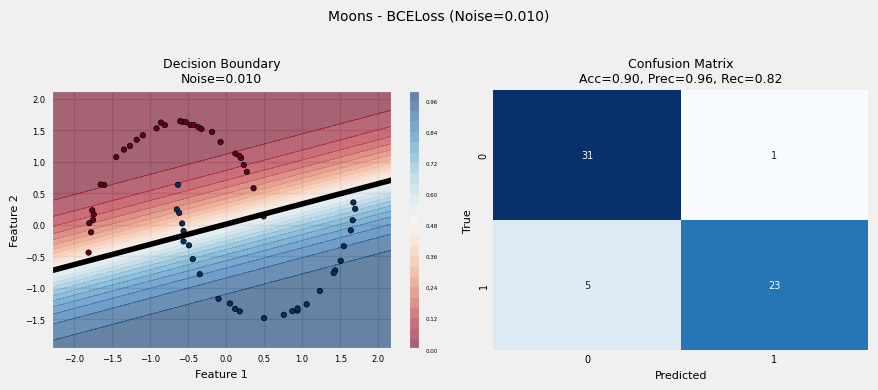

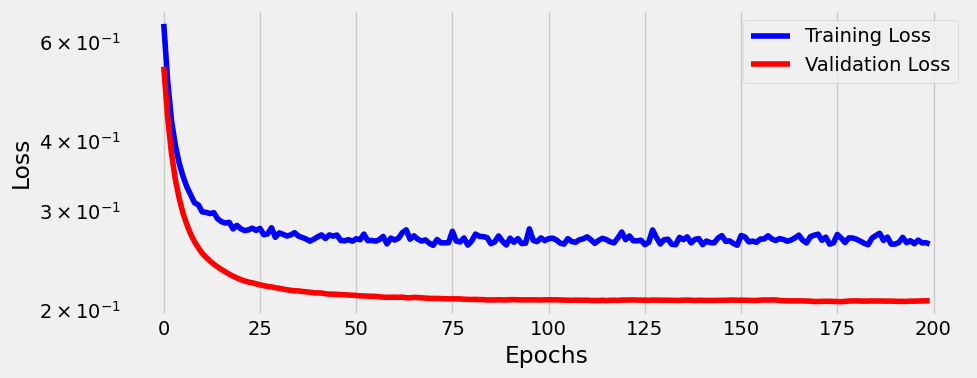

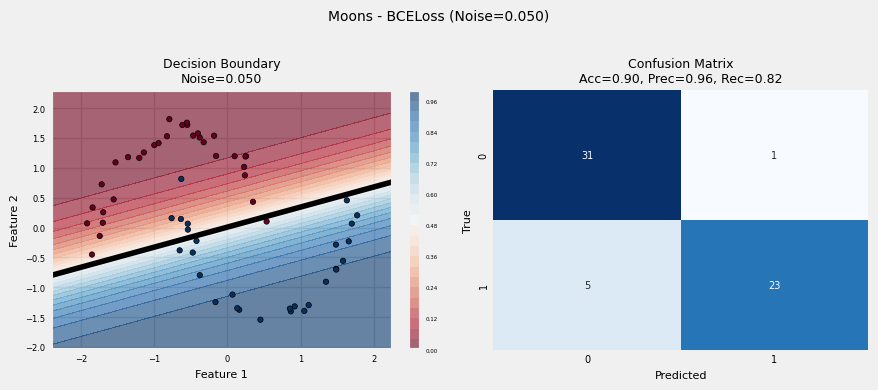

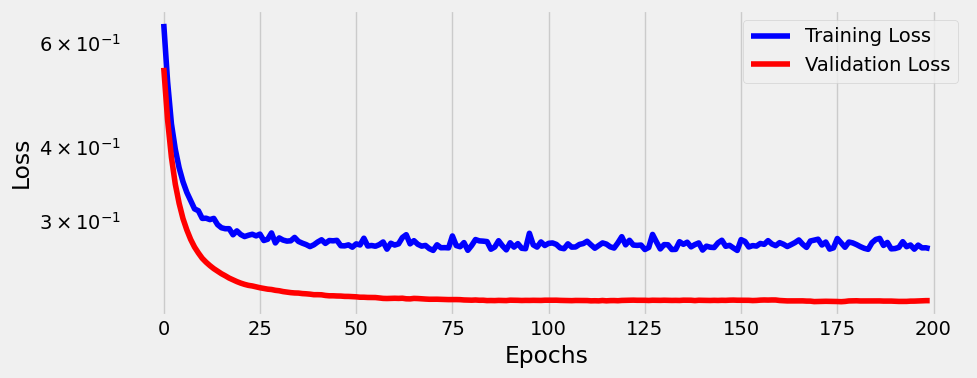

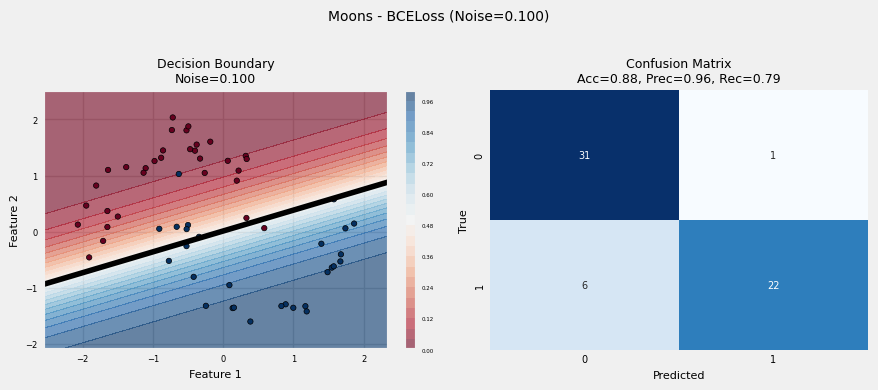

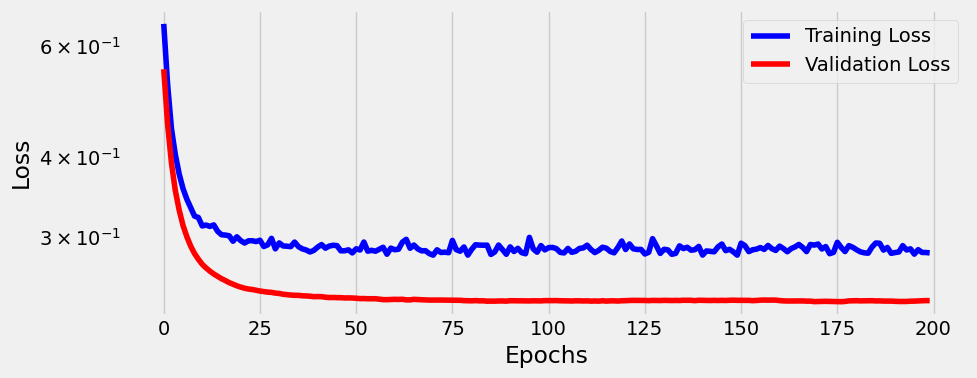

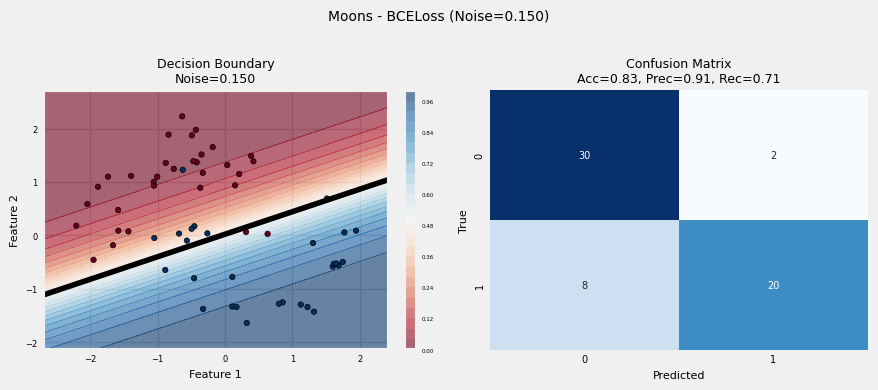

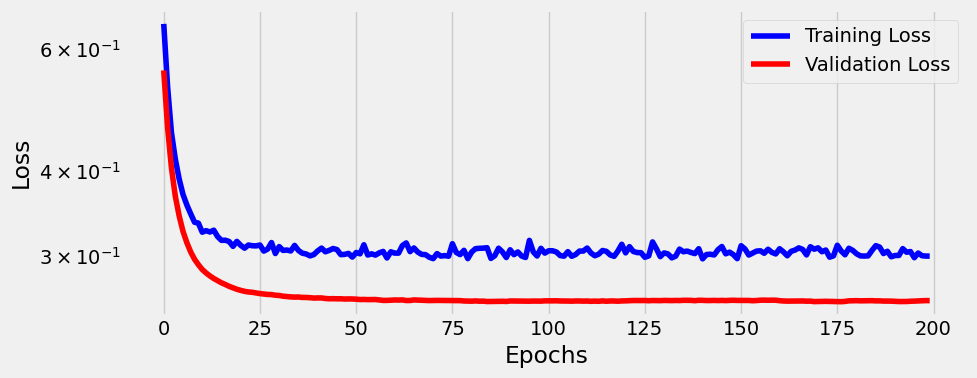

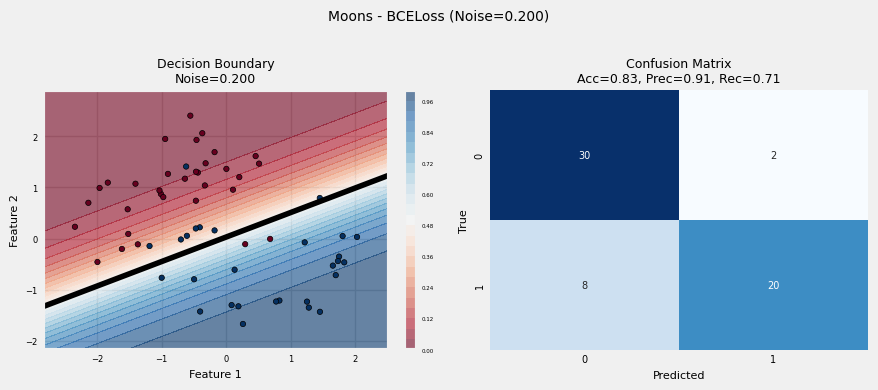

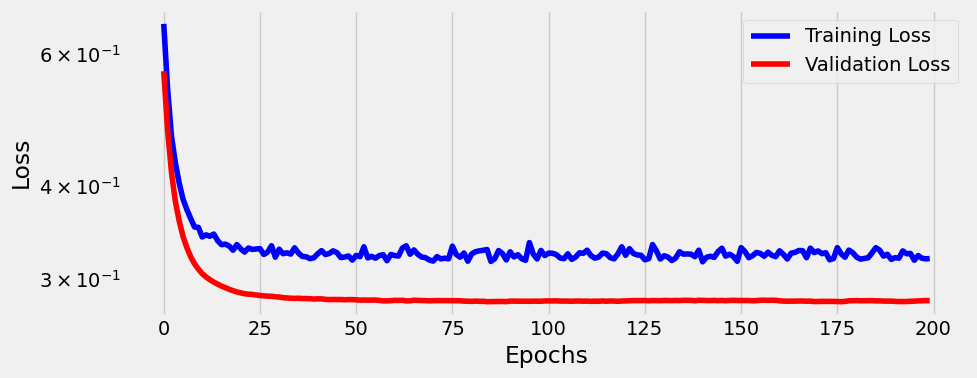

In [25]:
plot_metrics(archs[DataShape.MOONS]['BCELoss'], 'BCELoss', 'Moons')

This dataset is non-linearly separable, but we can see that the logistic regression tried to do its best here. As the noise increases our accuracy decreases as a result of the more blurred decision boundary,